In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import json

import tqdm.auto as tqdm
import sklearn.model_selection as model_selection
import sklearn.metrics as metrics
import transformers
import matplotlib.pyplot as plt
import seaborn as sns

All Data: 1217
Train Data: 1167
Test Data: 50


<Axes: >

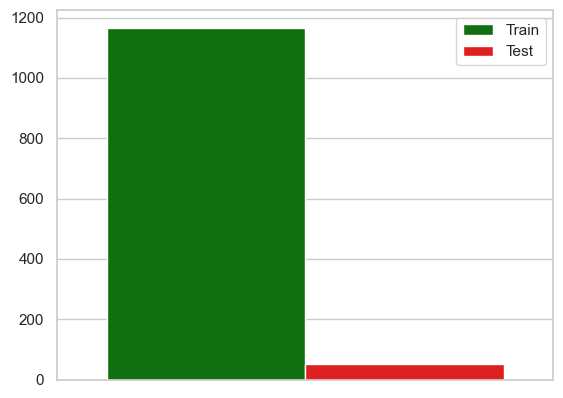

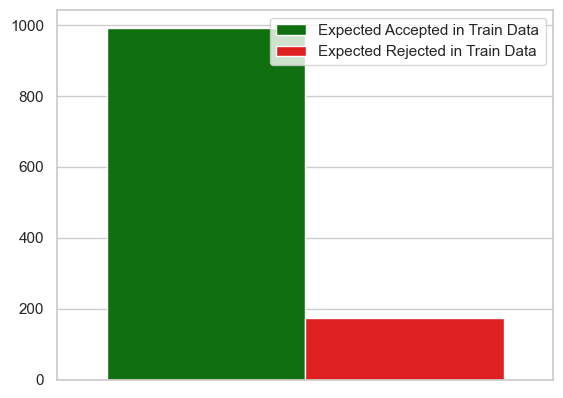

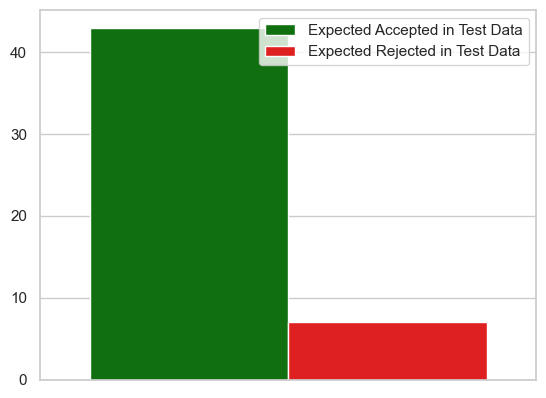

In [2]:
with open("../../data/training/train.json", "r", encoding="utf-8") as fp:
    train_reviews = json.load(fp)

with open("../../data/training/test.json", "r", encoding="utf-8") as fp:
    test_reviews = json.load(fp)


print(f"All Data: {len(train_reviews) + len(test_reviews)}")
print(f"Train Data: {len(train_reviews)}")
print(f"Test Data: {len(test_reviews)}")


sns.set_theme(style="whitegrid")

plt.figure()
sns.barplot(hue=["Train", "Test"], y=[len(train_reviews), len(test_reviews)], palette=["green", "red"])

plt.figure()
sns.barplot(hue=["Expected Accepted in Train Data", "Expected Rejected in Train Data"], y=[len([r for r in train_reviews if bool(r["conclusion"])]), len([r for r in train_reviews if not bool(r["conclusion"])])], palette=["green", "red"])

plt.figure()
sns.barplot(hue=["Expected Accepted in Test Data", "Expected Rejected in Test Data"], y=[len([r for r in test_reviews if bool(r["conclusion"])]), len([r for r in test_reviews if not bool(r["conclusion"])])], palette=["green", "red"])

In [4]:
class ReviewDataset(data.Dataset):
    def __init__(self, reviews):
        self.reviews = reviews

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, index):
        review = self.reviews[index]
        reason = str(review["reason"])
        rating = torch.tensor(review["rating"]).float()
        conclusion = F.one_hot(torch.tensor(review["conclusion"]), 2).float()
        return reason, rating, conclusion


train_dataset = ReviewDataset(train_reviews)
test_dataset = ReviewDataset(test_reviews)

print(f"Number of reviews in dataset: {len(train_dataset)}")
print(f"Number of reviews in dataset: {len(test_dataset)}")

Number of reviews in dataset: 1167
Number of reviews in dataset: 50


In [3]:
class ReviewModel(nn.Module):
    def __init__(self, rating_length = 7, device = "cpu", method = "concatenation"):
        super(ReviewModel, self).__init__()
        self.device = device
        self.method = method
        self.t5_tokenizer = transformers.AutoTokenizer.from_pretrained("google/t5-v1_1-base")
        self.t5_encoder = transformers.T5EncoderModel.from_pretrained("google/t5-v1_1-base").to(device)
        self.seq_1 = nn.Sequential(
            nn.Linear(rating_length, 16),
            nn.ReLU(),
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 768),
            nn.ReLU(),
        )
        if method == "concatenation":
            self.seq_2 = nn.Sequential(
                nn.Linear(1536, 256),
                nn.ReLU(),
                nn.Linear(256, 64),
                nn.ReLU(),
                nn.Linear(64, 16),
                nn.ReLU(),
                nn.Linear(16, 2),
                nn.Softmax(1)
            )
        elif method == "weighted_sum":
            self.weight_1 = torch.nn.Parameter(torch.randn(1, 768))
            self.weight_2 = torch.nn.Parameter(torch.randn(1, 768))
            self.seq_2 = nn.Sequential(
                nn.Linear(768, 256),
                nn.ReLU(),
                nn.Linear(256, 64),
                nn.ReLU(),
                nn.Linear(64, 16),
                nn.ReLU(),
                nn.Linear(16, 2),
                nn.Softmax(1)
            )

    def forward(self, ratings, reasons):
        ratings_output = self.seq_1(ratings)
        reasons_ids = self.t5_tokenizer(reasons, return_tensors="pt", padding=True, truncation=True).input_ids.to(self.device)
        reasons_output = self.t5_encoder(reasons_ids).last_hidden_state.mean(1)
        if self.method == "concatenation":
            output = torch.cat((ratings_output, reasons_output), 1)
        elif self.method == "weighted_sum":
            output = ratings_output * self.weight_1 + reasons_output * self.weight_2
        return self.seq_2(output)

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ReviewModel(device=device)
model.t5_encoder.requires_grad_(False)
model.to(device)

reason, ratings, conclusion = train_dataset[1]
ratings = ratings.unsqueeze(0).to(device)
conclusion = conclusion.unsqueeze(0).to(device)
output = model(ratings, reason)
print(output.shape)

torch.Size([1, 2])


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1
record_steps = 100
step = 0
losses = []

model = ReviewModel(device=device, method="weighted_sum")
model.t5_encoder.requires_grad_(False)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)


print("Training started\n")

model.to(device)
criterion.to(device)

for fold, (train_indices, validation_indices) in enumerate(kf.split(train_dataset)):
    print(f"Fold: {fold + 1}")

    train_data_loader = data.DataLoader(data.Subset(train_dataset, train_indices), batch_size=batch_size)
    validation_data_loader = data.DataLoader(data.Subset(train_dataset, validation_indices), batch_size=batch_size)

    model.train()
    for reason, ratings, conclusion in tqdm.tqdm(train_data_loader):
        optimizer.zero_grad()
        ratings = ratings.to(device)
        conclusion = conclusion.to(device)
        output = model(ratings, reason)
        loss = criterion(output, conclusion)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        step += 1

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for reason, ratings, conclusion in validation_data_loader:
            ratings = ratings.to(device)
            conclusion = conclusion.to(device)
            output = model(ratings, reason)
            _, predicted = torch.max(output, 1)
            _, truth = torch.max(conclusion, 1)
            total += conclusion.size(0)
            correct += (predicted == truth).sum().item()
        print(f"Validation accuracy: {correct / total:.4f}")

print("\nTraining finished")
print(f"Total steps: {step}")

Training started

Fold: 1


  0%|          | 0/1050 [00:00<?, ?it/s]

Validation accuracy: 0.8462
Fold: 2


  0%|          | 0/1050 [00:00<?, ?it/s]

Validation accuracy: 0.8974
Fold: 3


  0%|          | 0/1050 [00:00<?, ?it/s]

Validation accuracy: 0.8974
Fold: 4


  0%|          | 0/1050 [00:00<?, ?it/s]

Validation accuracy: 0.9658
Fold: 5


  0%|          | 0/1050 [00:00<?, ?it/s]

Validation accuracy: 0.9487
Fold: 6


  0%|          | 0/1050 [00:00<?, ?it/s]

Validation accuracy: 0.9402
Fold: 7


  0%|          | 0/1050 [00:00<?, ?it/s]

Validation accuracy: 0.9573
Fold: 8


  0%|          | 0/1051 [00:00<?, ?it/s]

Validation accuracy: 0.9310
Fold: 9


  0%|          | 0/1051 [00:00<?, ?it/s]

Validation accuracy: 0.9224
Fold: 10


  0%|          | 0/1051 [00:00<?, ?it/s]

Validation accuracy: 0.9828

Training finished
Total steps: 10503


In [46]:
torch.save(model.state_dict(), f"../checkpoints/DNN + T5 encoder ({model.method}).pth")

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
method = "concatenation"
model = ReviewModel(device=device, method=method)
model.load_state_dict(torch.load(f"../checkpoints/DNN + T5 encoder ({method}).pth"))

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


<All keys matched successfully>

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1

results = []
correct_count = 0


model.to(device)
with torch.no_grad():
    model.eval()
    test_data_loader = data.DataLoader(test_dataset, batch_size=batch_size)
    for reason, ratings, conclusion in test_data_loader:
        ratings = ratings.to(device)
        conclusion = conclusion.to(device)
        output = model(ratings, reason)
        _, predicted = torch.max(output, 1)
        _, truth = torch.max(conclusion, 1)
        results.append((predicted.item(), truth.item()))
        correct_count += (predicted == truth).sum().item()

predicts = [r[0] for r in results]
truths = [r[1] for r in results]

print(f"Precision: {metrics.precision_score(truths, predicts) * 100:.2f}%")
print(f"Recall: {metrics.recall_score(truths, predicts) * 100:.2f}%")
print(f"F1: {metrics.f1_score(truths, predicts) * 100:.2f}%")
print(f"AUROC: {metrics.roc_auc_score(truths, predicts) * 100:.2f}%")
print(f"Accuracy: {metrics.accuracy_score(truths, predicts) * 100:.2f}%")

Precision: 97.73%
Recall: 100.00%
F1: 98.85%
AUROC: 92.86%
Accuracy: 98.00%


In [ ]:
torch.save(model, f"../checkpoints/DNN + T5 encoder.pt")